In [1]:
!pip install spectra torch torch-geometric


In [2]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
!pip install torch-geometric



Looking in indexes: https://download.pytorch.org/whl/cpu


Epoch: 010, Loss: 1.8448, Train Acc: 0.9143, Val Acc: 0.6120, Test Acc: 0.6290
Epoch: 020, Loss: 1.6775, Train Acc: 0.9571, Val Acc: 0.7580, Test Acc: 0.7750
Epoch: 030, Loss: 1.4891, Train Acc: 0.9643, Val Acc: 0.7460, Test Acc: 0.7710
Epoch: 040, Loss: 1.2602, Train Acc: 0.9571, Val Acc: 0.7460, Test Acc: 0.7750
Epoch: 050, Loss: 1.0839, Train Acc: 0.9643, Val Acc: 0.7900, Test Acc: 0.8120
Epoch: 060, Loss: 0.8981, Train Acc: 0.9714, Val Acc: 0.7880, Test Acc: 0.8160
Epoch: 070, Loss: 0.7542, Train Acc: 0.9643, Val Acc: 0.7840, Test Acc: 0.8110
Epoch: 080, Loss: 0.6584, Train Acc: 0.9857, Val Acc: 0.7920, Test Acc: 0.8220
Epoch: 090, Loss: 0.5880, Train Acc: 0.9857, Val Acc: 0.7880, Test Acc: 0.8190
Epoch: 100, Loss: 0.5227, Train Acc: 0.9857, Val Acc: 0.7840, Test Acc: 0.8140
Epoch: 110, Loss: 0.4960, Train Acc: 0.9857, Val Acc: 0.7900, Test Acc: 0.8190
Epoch: 120, Loss: 0.4512, Train Acc: 0.9857, Val Acc: 0.7840, Test Acc: 0.8150
Epoch: 130, Loss: 0.4751, Train Acc: 0.9929, Val Acc

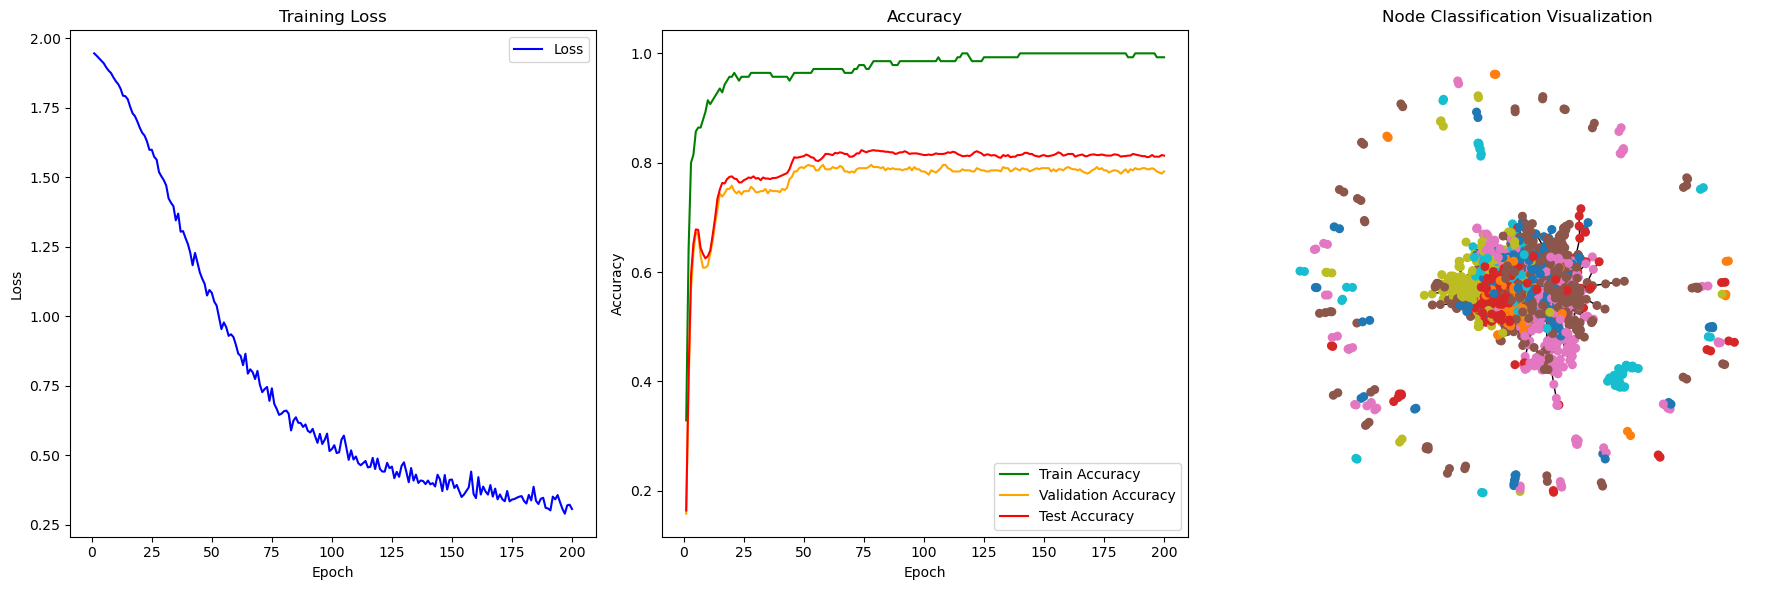

In [4]:
# Import libraries
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.utils import to_networkx

# Load the Cora dataset
dataset = Planetoid(root='data/Cora', name='Cora', transform=NormalizeFeatures())
data = dataset[0]

# Define the GCN model
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Initialize the model, optimizer, and loss function
model = GCN(in_channels=dataset.num_features, hidden_channels=16, out_channels=dataset.num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.NLLLoss()

# Set device (GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model, data = model.to(device), data.to(device)

# Lists to store results for plotting
losses = []
train_accuracies = []
val_accuracies = []
test_accuracies = []

# Train the model
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

# Test the model
def test():
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)

    accs = []
    for mask in [data.train_mask, data.val_mask, data.test_mask]:
        correct = (pred[mask] == data.y[mask]).sum()
        acc = int(correct) / int(mask.sum())
        accs.append(acc)
    return accs

# Training loop
for epoch in range(1, 201):
    loss = train()
    train_acc, val_acc, test_acc = test()
    
    # Store metrics for plotting
    losses.append(loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    test_accuracies.append(test_acc)

    # Print metrics every 10 epochs
    if epoch % 10 == 0:
        print(f"Epoch: {epoch:03d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}")

# Final test accuracy
_, _, test_acc = test()
print(f"Final Test Accuracy: {test_acc:.4f}")

# Plot the results
plt.figure(figsize=(18, 6))

# Plot training loss
plt.subplot(1, 3, 1)
plt.plot(range(1, 201), losses, label='Loss', color='blue')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot accuracies
plt.subplot(1, 3, 2)
plt.plot(range(1, 201), train_accuracies, label='Train Accuracy', color='green')
plt.plot(range(1, 201), val_accuracies, label='Validation Accuracy', color='orange')
plt.plot(range(1, 201), test_accuracies, label='Test Accuracy', color='red')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Visualize node classification
plt.subplot(1, 3, 3)
model.eval()
out = model(data.x, data.edge_index)
pred = out.argmax(dim=1)

# Convert PyG graph to NetworkX graph
G = to_networkx(data, to_undirected=True)
node_colors = pred.cpu().numpy()

# Draw the graph
plt.title("Node Classification Visualization")
nx.draw(G, node_size=30, node_color=node_colors, cmap=plt.cm.tab10, with_labels=False)

plt.tight_layout()
plt.show()


Epoch: 010, Loss: 1.8532, Train Acc: 0.8071, Val Acc: 0.4940, Test Acc: 0.5400
Epoch: 020, Loss: 1.7238, Train Acc: 0.9357, Val Acc: 0.7000, Test Acc: 0.7200
Epoch: 030, Loss: 1.5446, Train Acc: 0.9643, Val Acc: 0.7340, Test Acc: 0.7420
Epoch: 040, Loss: 1.3108, Train Acc: 0.9714, Val Acc: 0.7480, Test Acc: 0.7770
Epoch: 050, Loss: 1.0920, Train Acc: 0.9643, Val Acc: 0.7720, Test Acc: 0.7840
Epoch: 060, Loss: 0.9139, Train Acc: 0.9714, Val Acc: 0.7800, Test Acc: 0.7980
Epoch: 070, Loss: 0.7402, Train Acc: 0.9786, Val Acc: 0.7800, Test Acc: 0.8000
Epoch: 080, Loss: 0.6748, Train Acc: 0.9857, Val Acc: 0.7820, Test Acc: 0.8080
Epoch: 090, Loss: 0.6020, Train Acc: 0.9929, Val Acc: 0.7800, Test Acc: 0.8000
Epoch: 100, Loss: 0.5313, Train Acc: 0.9929, Val Acc: 0.7760, Test Acc: 0.8110
Epoch: 110, Loss: 0.5227, Train Acc: 0.9929, Val Acc: 0.7780, Test Acc: 0.8100
Epoch: 120, Loss: 0.4669, Train Acc: 0.9929, Val Acc: 0.7820, Test Acc: 0.8140
Epoch: 130, Loss: 0.4122, Train Acc: 0.9929, Val Acc

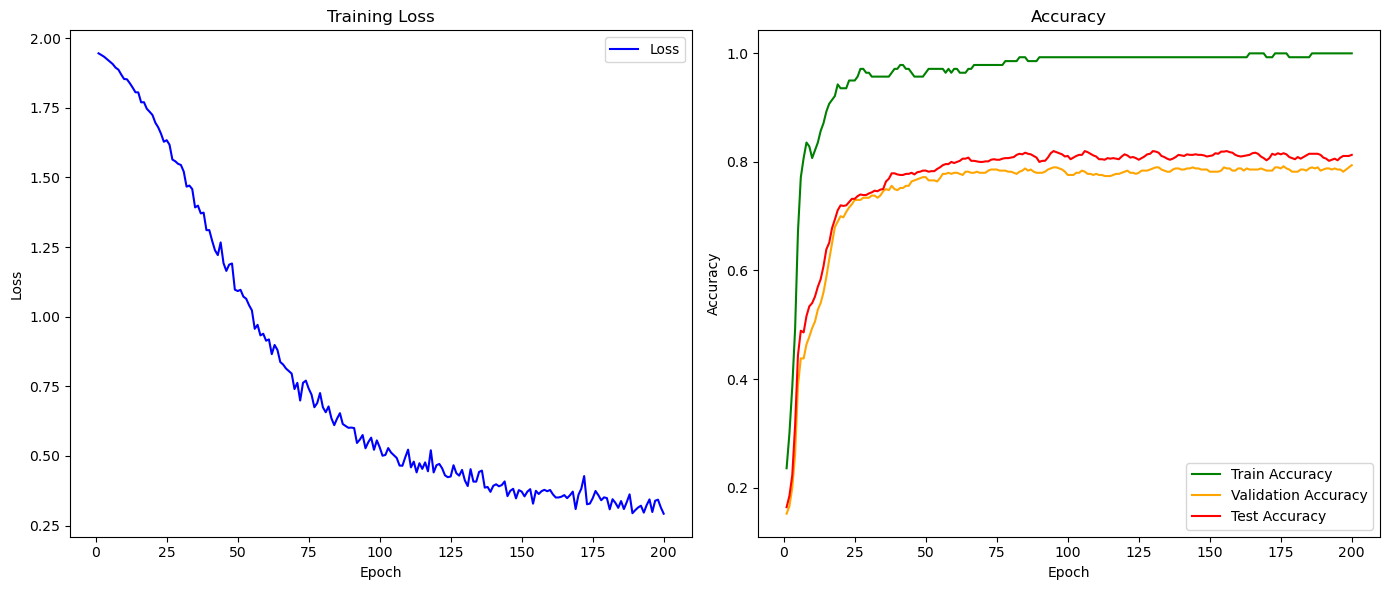

In [6]:
# Import libraries
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
import matplotlib.pyplot as plt

# Load the Cora dataset
dataset = Planetoid(root='data/Cora', name='Cora', transform=NormalizeFeatures())
data = dataset[0]

# Define the GCN model
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        # First Graph Convolution Layer
        x = self.conv1(x, edge_index)
        x = F.relu(x)  # Activation Function
        x = F.dropout(x, training=self.training)  # Dropout Regularization
        # Second Graph Convolution Layer
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)  # Log-Softmax for Node Classification

# Initialize the model, optimizer, and loss function
model = GCN(in_channels=dataset.num_features, hidden_channels=16, out_channels=dataset.num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.NLLLoss()  # Negative Log-Likelihood Loss for Classification

# Set device (GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model, data = model.to(device), data.to(device)

# Lists to store loss and accuracy for visualization
losses = []
train_accuracies = []
val_accuracies = []
test_accuracies = []

# Define the training function
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)  # Forward pass
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute loss on training set
    loss.backward()  # Backward pass
    optimizer.step()  # Update model parameters
    return loss.item()

# Define the testing function
def test():
    model.eval()
    out = model(data.x, data.edge_index)  # Forward pass
    pred = out.argmax(dim=1)  # Predicted classes

    accs = []
    for mask in [data.train_mask, data.val_mask, data.test_mask]:
        correct = (pred[mask] == data.y[mask]).sum()
        acc = int(correct) / int(mask.sum())
        accs.append(acc)
    return accs  # Return accuracies for train, validation, and test sets

# Training loop
for epoch in range(1, 201):  # Train for 200 epochs
    loss = train()  # Train the model for one epoch
    train_acc, val_acc, test_acc = test()  # Evaluate the model

    # Store metrics for visualization
    losses.append(loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    test_accuracies.append(test_acc)

    # Print metrics every 10 epochs
    if epoch % 10 == 0:
        print(f"Epoch: {epoch:03d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}")

# Final test accuracy
_, _, final_test_acc = test()
print(f"\nFinal Test Accuracy: {final_test_acc:.4f}")

# Plotting the results
plt.figure(figsize=(14, 6))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(range(1, 201), losses, label='Loss', color='blue')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot accuracies
plt.subplot(1, 2, 2)
plt.plot(range(1, 201), train_accuracies, label='Train Accuracy', color='green')
plt.plot(range(1, 201), val_accuracies, label='Validation Accuracy', color='orange')
plt.plot(range(1, 201), test_accuracies, label='Test Accuracy', color='red')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
